In [1]:
# Preprocessing
%load_ext autoreload
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/iprovilkov/data/JUNO/notebooks/')

In [2]:
from data_utils.data_processing import get_data_2dprojection
from data_utils.data_generator import DataGenerator

Using TensorFlow backend.


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100000,20000)
MAXR = 17200

In [5]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
NAME = 'Simple_CNN_xyz_full'
train_columns = ['x', 'y', 'z']

In [7]:
model = Sequential()
model.add(L.Conv2D(filters= 32, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters= 64, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(1024, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
#model.add(L.Dropout(0.3))
model.add(L.Dense(512, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(256, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(len(train_columns)))

In [8]:
opt = Adam()

In [9]:
edge_size0 = 226
edge_size1 = 112
inputs = Input(shape=(edge_size0,edge_size1,2))

In [10]:
model.build(input_shape=(None, edge_size0,edge_size1,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 110, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 55, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 53, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 10, 256)       295168    
__________

In [11]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [12]:
logdir = NAME + '.csv'

In [13]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau
csv_logger = CSVLogger(logdir, append=True, separator=';')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.000001)

In [14]:
big_file_names = []
rg = np.arange(0,100001,20000)
#mask_names = []
y_true_names = []
for id1 in range(9):
    for start in rg[:-1]:
        big_file_names.append(LTRAIN + '_' + str(id1) + '_' + str(start) + 'noise_sin.npy')
    #mask_names.append(LTRAIN +'_'+str(id1)+'_mask.npy')
    y_true_names.append(LTRAIN +'_'+str(id1)+'_true_info.csv')

In [21]:
small_file_names = [LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]]

In [15]:
y_true_names

['/mnt/iprovilkov/data_dir/npdata/_0_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_1_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_2_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_3_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_4_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_5_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_6_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_7_true_info.csv',
 '/mnt/iprovilkov/data_dir/npdata/_8_true_info.csv']

In [16]:
TRAIN_DIR = '~/data/data_dir/'
#tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')
tr_true_info = pd.read_csv(y_true_names[-1])

In [18]:
big_file_names[-1]

'/mnt/iprovilkov/data_dir/npdata/_8_80000noise_sin.npy'

In [19]:
#X_test = np.load(LTRAIN + '_' + str(rg[-3]) +'without_noise_sin.npy')
X_test = np.load(big_file_names[-1])

In [20]:
y_test = tr_true_info[(tr_true_info['evtID'] >= 80000) 
                     & (tr_true_info['evtID'] < 100000)]
mask = (y_test.R <= MAXR)
X_test = X_test[mask]
y_test = y_test[mask][train_columns].values

In [21]:
def scaler(X,y):
    X[X<0]=0
    X[:,:,:,1] /= 20 
    y /= 100

In [22]:
scaler(X_test, y_test)

In [23]:
rg = np.arange(0,100001,20000)

In [24]:
%autoreload

In [25]:
from data_utils.data_generator import DataGeneratorBig

In [26]:
# big size 9, small size 5

In [27]:
training_generator = DataGeneratorBig(32,
                                    rg=rg,
                                    file_names=big_file_names,
                                    y_true_names= y_true_names,
                                    target_names=train_columns,
                                    scaler=scaler)

Big pieces 9
Small pieces 5

 Big id  0 small id 0

 Load files /mnt/iprovilkov/data_dir/npdata/_0_0noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_0_true_info.csv
Ids from:  0  to  20000


In [28]:
#training_generator = DataGenerator(16,rg=rg,
#                                file_names=[LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]],
#                                  y_true=tr_true_info,
#                                  target_names=train_columns,
#                                  scaler=scaler)

In [ ]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=10,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*20)

Epoch 1/80
572/573 [============================>.] - ETA: 0s - loss: 1.1928
 Big id  7 small id 1

 Load files /mnt/iprovilkov/data_dir/npdata/_7_20000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_7_true_info.csv
Ids from:  20000  to  40000
573/573 [==============================] - 62s 107ms/step - loss: 1.1926 - val_loss: 1.2211
Epoch 2/80
572/573 [============================>.] - ETA: 0s - loss: 1.1850
 Big id  7 small id 2

 Load files /mnt/iprovilkov/data_dir/npdata/_7_40000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_7_true_info.csv
Ids from:  40000  to  60000
573/573 [==============================] - 64s 112ms/step - loss: 1.1858 - val_loss: 1.2197
Epoch 3/80
572/573 [============================>.] - ETA: 0s - loss: 1.2231
 Big id  7 small id 3

 Load files /mnt/iprovilkov/data_dir/npdata/_7_60000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_7_true_info.csv
Ids from:  60000  to  80000
573/573 [==============================] - 59s 103ms/step - loss: 1.2228 - val_lo

Ids from:  0  to  20000
573/573 [==============================] - 61s 107ms/step - loss: 1.0788 - val_loss: 1.2081
Epoch 26/80
572/573 [============================>.] - ETA: 0s - loss: 1.1563
 Big id  3 small id 1

 Load files /mnt/iprovilkov/data_dir/npdata/_3_20000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_3_true_info.csv
Ids from:  20000  to  40000
573/573 [==============================] - 59s 103ms/step - loss: 1.1561 - val_loss: 1.2087
Epoch 27/80
572/573 [============================>.] - ETA: 0s - loss: nan
 Big id  3 small id 2

 Load files /mnt/iprovilkov/data_dir/npdata/_3_40000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_3_true_info.csv
Ids from:  40000  to  60000
573/573 [==============================] - 66s 115ms/step - loss: nan - val_loss: 1.2118
Epoch 28/80
572/573 [============================>.] - ETA: 0s - loss: 1.1662
 Big id  3 small id 3

 Load files /mnt/iprovilkov/data_dir/npdata/_3_60000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_3_true_info.

In [72]:
model.save_weights(NAME + '.h5')
with open(NAME + ".json", "w") as json_file:
    json_file.write(model.to_json())

(0, 3)

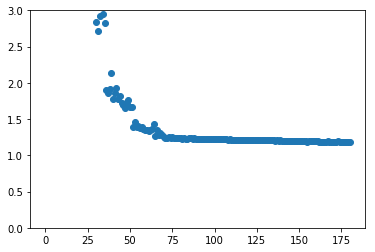

In [49]:
cs = pd.read_csv(logdir, sep=';')
cs = cs
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,3)

In [50]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [51]:
preds = model.predict(X_test)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [52]:
preds[:3]

array([[  31.538763,  124.30069 ,   94.52486 ],
       [-110.02735 ,  -78.9218  ,  -85.23902 ],
       [-120.45521 ,  -58.44297 ,   73.7195  ]], dtype=float32)

In [53]:
y_test[:3]

array([[  30.843179,  124.239   ,   94.68604 ],
       [-110.4834  ,  -79.31076 ,  -85.36656 ],
       [-121.42451 ,  -59.139478,   73.525874]])

In [54]:
test_resultsE.mean() * 10

12.213124564306135

In [55]:
r_res = tr_true_info[(tr_true_info['evtID'] >= rg[-2]) 
             & (tr_true_info['evtID'] < rg[-1])]['R'][mask].values

In [56]:
r_pred = np.sqrt(preds[:,0] ** 2 + preds[:,1] ** 2 + preds[:,2] ** 2) * 100

In [57]:
r_pred

array([15931.196, 16000.113, 15283.849, ..., 16515.133, 13311.301,
       13668.663], dtype=float32)

In [58]:
np.std(r_pred-r_res)/10

11.035977779172383

In [59]:
preds[:,0]

array([  31.538763  , -110.02735   , -120.45521   , ...,    0.12954655,
       -101.10551   ,   79.116394  ], dtype=float32)

In [60]:
from tqdm import tqdm

In [61]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [62]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                print("Compute...")
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits,
                                                None,
                                                pos,
                                                true_info,
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
                np.save(test_dir+str(energy)+'data_lpmt_without_noise_sin', data_lpmt)
            else:
                pass
            
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        y_test = true_info[test_column].values
        scaler(data_lpmt, 0)
        
        preds = model.predict(data_lpmt)
        r_pred = np.sqrt(preds[:,0] ** 2 + preds[:,1] ** 2 + preds[:,2] ** 2) * 100
        
        
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(r_pred, y_test)
        # in percents
        if test_column == 'E':
            sigmas[energy] = np.std(preds - y_test) / (energy + CONST)
        if test_column == 'R':
            print(preds[:10])
            print(y_test[:10])
            sigmas[energy] = np.std(r_pred - y_test)
    print("+")
    return sigmas, MSEs, predictions

In [63]:
sigmas, MSEs, predictions = test_sigmas(model, test_column='R', time=True, recompute=False)

 10%|█         | 1/10 [00:02<00:26,  2.93s/it]

[[  55.344482  -60.355312  110.22082 ]
 [-117.407166  -69.16548   -21.858599]
 [  12.253041 -132.52061   -58.084858]
 [  52.24215    11.483846 -151.84348 ]
 [ -46.398476   45.45584  -153.18028 ]
 [ -80.553055    9.35012   138.3744  ]
 [ -34.382393   45.093967  120.65558 ]
 [  34.733017   35.691833  137.7899  ]
 [ -24.59612  -112.89876    49.382404]
 [  -9.439381 -118.09786   -22.434525]]
[13685.387 13767.972 14483.374 16385.209 16535.102 16292.973 13321.352
 14847.134 12601.948 12191.814]


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

[[  57.27662    -62.0935     107.21826  ]
 [  35.166077    21.132559   126.427475 ]
 [ -83.65771     -7.7610235  -45.088703 ]
 [-105.927155    -8.716172   -92.22533  ]
 [  36.008217   -25.925083    89.647095 ]
 [ -65.545975    38.6954      40.895008 ]
 [ -16.722792    99.6018     119.33353  ]
 [  19.444374    64.28963     47.553185 ]
 [   3.5766199   50.13046    -43.005554 ]
 [ -47.62308     76.61545    105.17809  ]]
[13685.387  13410.883   9433.555  13953.234   9949.386   8924.891
 15597.524   8686.9375  6877.779  13697.783 ]


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

[[  55.341854   -61.197163   108.07552  ]
 [  17.012583   -47.54584     79.33787  ]
 [  76.36833   -124.5739      17.10772  ]
 [-102.40682    -32.979595    23.911215 ]
 [  -7.401595   145.70833    -40.059727 ]
 [  69.64174      2.534109    70.08173  ]
 [ -96.91044     27.992495    82.22395  ]
 [ -33.386944    43.978603    14.181444 ]
 [ -20.77929     40.87045    163.07547  ]
 [   6.6892047  -34.228485   -18.065748 ]]
[13685.387   9459.184  14780.856  11244.336  15168.536   9857.545
 13065.209   5716.9985 17010.791   3766.2598]


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

[[  56.86583   -60.943554  108.96009 ]
 [  38.809006  -80.477516  125.12375 ]
 [  47.632137 -139.22638    22.154663]
 [ -18.624798  112.3882    -42.661293]
 [  32.04388   121.982346   87.17846 ]
 [ -53.22531   110.66852   -95.237595]
 [  -9.464027 -120.8142     44.030586]
 [  37.485687   80.57736   -98.37379 ]
 [  70.327644   89.35014   -39.381138]
 [ 101.57102   121.9197    -22.027596]]
[13685.387 15327.389 14982.    12146.219 15341.161 15562.079 13139.039
 13423.874 12005.3   15854.112]


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

[[  56.67275    -60.667915   108.46835  ]
 [ -74.18627   -112.26456    -47.0917   ]
 [ 111.14911    -14.569541    -3.3161366]
 [ 119.14265    -45.021793   -59.891487 ]
 [  -2.604862   -89.03367    -53.833176 ]
 [  91.558075     2.1195216  -51.59555  ]
 [  -9.010126  -116.79373     61.06873  ]
 [ -28.965603     9.983181   -76.61865  ]
 [  64.56126    -29.22115     87.59893  ]
 [  45.546356  -150.48276     23.491224 ]]
[13685.387  14200.797  11200.73   14083.442  10510.377  10500.41
 13247.246   8158.7183 11431.432  15828.905 ]


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

[[  56.816475   -60.220432   109.046906 ]
 [  33.457226   -74.5249     -20.55152  ]
 [  46.745415   102.313034    44.491947 ]
 [ -66.767105    74.7437    -131.91362  ]
 [  32.215256   -91.54103     63.14384  ]
 [-102.53541    -98.62518     66.69566  ]
 [ 116.587845   110.339005    19.273396 ]
 [ 114.20843    -80.36577    -78.02734  ]
 [-151.16681     36.00773     59.853947 ]
 [  10.0474825  -54.878326  -106.0933   ]]
[13685.387  8422.246 12181.572 16394.582 11673.857 15601.306 16126.187
 16045.935 16654.432 12175.233]


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

[[  57.22146    -60.849247   108.21455  ]
 [ -19.27727    -55.366318   104.10144  ]
 [-105.45537    -48.36847    -35.907383 ]
 [ -97.30103     61.187057    -4.1110473]
 [  71.592445  -115.425995    18.687586 ]
 [ -24.446938   120.54658    -65.37521  ]
 [  52.077484  -127.89331    100.92151  ]
 [  29.190592    66.42532    -71.18797  ]
 [ -46.17807    107.25946    -26.564762 ]
 [ -35.148075  -108.56701    -57.123314 ]]
[13685.387 11922.321 12114.285 11516.515 13680.285 13979.825 17108.254
 10130.919 11991.952 12682.488]


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

[[  56.63642    -60.58035    108.34002  ]
 [  27.431911    48.57254   -117.81104  ]
 [  95.18195    105.451035    34.83419  ]
 [   7.3759737   79.97618    108.84739  ]
 [ -40.057205  -153.89403    -60.403053 ]
 [ -91.94046   -101.66633    -44.56155  ]
 [  43.67634    -78.29991    -76.52829  ]
 [  75.91127    -68.424164    91.48289  ]
 [   2.7765317   -0.8949674  -90.54385  ]
 [ -27.683983    29.754023  -111.42419  ]]
[13685.387 12958.754 14612.41  13395.118 17146.44  14422.13  11942.524
 13709.816  9141.089 11901.334]


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

[[  59.300278  -59.75694   108.84445 ]
 [-138.74834   -37.449486   -9.017584]
 [-144.20715    15.257975   61.547638]
 [ 127.61786    30.62813   -20.5008  ]
 [ -86.807495   40.00817     5.537178]
 [ -75.70889   -99.83735    45.992764]
 [  12.284542   25.373919  -37.532394]
 [  18.002064   49.231445  -74.6478  ]
 [ -46.25576    28.032978   90.8059  ]
 [ -29.568832   56.318718  -64.82807 ]]
[13685.387  14392.851  15712.894  13303.8545  9530.68   13284.986
  4756.147   9080.496  10546.205   9097.196 ]


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

[[  57.217495   -60.21495    109.52175  ]
 [ -67.30224     43.92557     75.7127   ]
 [ 132.00722     30.121443   -80.43932  ]
 [ -10.475736    -4.4929495  -26.63775  ]
 [ -20.031738    39.245754   108.29133  ]
 [-111.89796     40.632427   120.620415 ]
 [  37.425854   152.01472     55.3621   ]
 [ -45.310715  -114.88446    -42.545757 ]
 [  63.57056    115.12008    -76.30216  ]
 [  93.845795    13.6405115  -12.999725 ]]
[13685.387 11129.92  15775.158  2958.306 11732.66  16947.965 16712.424
 13047.53  15077.495  9472.099]
+


In [64]:
sigmas, MSEs

({0: 214.69821483063777,
  1: 139.12629265129735,
  2: 119.97568904411918,
  3: 106.90482615002526,
  4: 103.86832068348495,
  5: 94.9450558659101,
  6: 98.98616589636212,
  7: 94.30723598650276,
  8: 97.72463004958817,
  9: 98.37701800636415},
 {0: 46102.25095467928,
  1: 19610.24468432632,
  2: 14544.981715656715,
  3: 11500.425380149169,
  4: 10857.19225709465,
  5: 9028.26604687741,
  6: 9827.720503299977,
  7: 8898.718589609492,
  8: 9563.02956838598,
  9: 9680.372760699014})

In [66]:
test_dir = '/mnt/iprovilkov/data_dir/'

In [67]:
lpmt_hits = pd.read_hdf(test_dir + str(0)+'MeV_'+ 'lpmt_hits.h5', mode='r') 

In [70]:
true_info = pd.read_csv(TRAIN_DIR + str(0)+'MeV_'+'true_info.csv')

In [71]:
true_info[:5]

,E,R,evtID,x,y,z
0,0.510999,13685.387,0,5702.9033,-6107.5576,10838.1020
1,0.510999,13767.972,1,-11704.7300,-6907.6904,-2200.0312
2,0.510999,14483.374,2,1473.3042,-13208.8720,-5755.2754
3,0.510999,16385.209,3,4844.6970,1258.4382,-15601.9340
4,0.510999,16535.102,4,-4589.3945,4687.0960,-15178.2140


R prediction for 0 part

In [76]:
rg

array([     0,  20000,  40000,  60000,  80000, 100000])

In [101]:
pred_list = []

In [102]:
for i, start in tqdm(enumerate(rg[:-1])):
    X = np.load(big_file_names[i])
    y_test = tr_true_info[(tr_true_info['evtID'] >= rg[i]) 
                     & (tr_true_info['evtID'] < rg[i+1])]
    #mask = (y_test.R <= MAXR)
    #X = X[mask]
    #y_test = y_test[mask][train_columns].values
    scaler(X, 0)
    predictions = model.predict(X)
    pred_list.append(predictions)


0it [00:00, ?it/s]
1it [00:26, 26.39s/it]
2it [00:57, 27.81s/it]
3it [01:29, 29.17s/it]
4it [01:59, 29.33s/it]
5it [02:29, 29.41s/it]

In [103]:
stacked = np.vstack(pred_list)

In [104]:
stacked.shape

(100000, 3)

In [105]:
CNN_xyz_R = np.sqrt(stacked[:,0] ** 2 + stacked[:,1] ** 2 + stacked[:,2] ** 2)

In [106]:
CNN_xyz_R

array([102.47714 ,  73.79576 ,  47.86174 , ...,  66.08299 ,  49.554005,
        65.986145], dtype=float32)

In [107]:
CNN_xyz_R.shape

(100000,)

In [108]:
np.save(LTRAIN + 'CNN_xyz_R', CNN_xyz_R)

In [109]:
np.save(LTRAIN + 'CNN_xyz', stacked)